In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Prepare data
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
root = "/tmp"
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 1000

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

for X_train, y_train in train_loader:
    break
for X_val, y_val in test_loader:
    break
    
if True:
    X_train = X_train.double()
    X_val = X_val.double()
    
if torch.cuda.is_available():
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

In [3]:
# Build model
from tda.models import pytorch_lenet
lenet = pytorch_lenet.LeNet()
lenet.train_or_load()
if torch.cuda.is_available():
    lenet = lenet.cuda()

2020-05-22 00:44:52,573 - Devices - INFO - Found 0 devices compatible with CUDA


Loaded LeNet_pretrained.pth


In [4]:
# Load or train model
lenet.train_or_load(train_loader=[(X_train, y_train)], val_data=(X_val, y_val),
                    num_epochs=50)

Loaded LeNet_pretrained.pth


In [5]:
# Build architecture (tda pipeline terminology)
import tda.models.architectures.parser as parser
from imp import reload
reload(parser)

x = X_train[0]
lenet_arch = parser.model_to_architecture(lenet, name="mnist_lenet",
                                          x=x)

2020-05-22 00:44:53,148 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7f40bc2f1410> received input with shape torch.Size([1, 1, 28, 28])
2020-05-22 00:44:53,149 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7f40bc2fb110> received input with shape torch.Size([1, 20, 12, 12])


In [6]:
from tda.graph import Graph

graph = Graph.from_architecture_and_data_point(lenet_arch, x)
for key in graph._edge_dict:
    layer_matrix = graph._edge_dict[key]
    print(layer_matrix.shape)

(11520, 784)
(2880, 11520)
(3200, 2880)
(800, 3200)
(500, 800)
(10, 500)


In [7]:
# Compute thresholds
from tda.thresholds import process_thresholds

class Dataset(object):
    def __init__(self, name, X_train, y_train, X_test, y_test):
        self.name = name
        self.train_dataset = list(zip(X_train, y_train))
        self.test_and_val_dataset = list(zip(X_test, y_test))
        
    def __str__(self):
        return self.name
    
# %debug
threshold = 0.05
raw_thresholds = "_".join([str(threshold)] * len(lenet_arch.layers))
dataset = Dataset("mnist", X_train, y_train, X_val, y_val)
thresholds = process_thresholds(architecture=lenet_arch,
                                dataset=dataset,
                                raw_thresholds=raw_thresholds,
                                dataset_size=10)

2020-05-22 00:44:54,483 - Cache - INFO - Cache root /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache/
2020-05-22 00:44:54,491 - Thresholds - INFO - Detected legacy format for thresholds
2020-05-22 00:44:54,492 - Thresholds - INFO - My received thresholds {(-1, 0): 0.05, (0, 1): 0.05, (1, 2): 0.05, (2, 3): 0.05, (3, 4): 0.05, (4, 5): 0.05}
2020-05-22 00:44:54,492 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_stats/architecture=mnist_lenet_e_0_dataset=mnist_dataset_size=10.cached for the call to get_stats
2020-05-22 00:44:54,627 - Thresholds - INFO - Link (-1, 0): threshold=4827.854064753056 (quantile 0.05)
2020-05-22 00:44:54,627 - Thresholds - INFO - Link (0, 1): threshold=40789.049309166796 (quantile 0.05)
2020-05-22 00:44:54,743 - Thresholds - INFO - Link (1, 2): threshold=221.87162671671533 (quantile 0.05)
2020-05-22 00:44:54,744 - Thresholds - INFO - Link (2, 3): threshold=14044.800388414802 (quantile 0.05)
2020-05-22 

In [8]:
# Build tda dataset (i.e activation graphs for clean and adversarial inputs)
from tda.protocol import get_protocolar_datasets

# %debug
lims = X_train.min(), X_train.max()
dataset_size = 500
all_epsilons = [0.01, .02, 0.05, 0.1, 0.2, 0.3, 0.4]
(train_clean, test_clean, train_adv,
 test_adv) = get_protocolar_datasets(dataset=dataset,
                                     succ_adv=True,
                                     dataset_size=dataset_size,
                                     noise=0., compute_graph=False,
                                     all_epsilons=all_epsilons,
                                     attack_type="FGSM_art",
                                     archi=lenet_arch,
                                     lims=lims)

2020-05-22 00:44:54,811 - C3PO - INFO - I will produce for you the protocolar datasets !
2020-05-22 00:44:54,813 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=False_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=100_epsilon=0.0_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_offset=0_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset
2020-05-22 00:44:54,819 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=False_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=100_epsilon=0.0_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_offset=100_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset
2020-05-22 00:44:54,824 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robus

In [9]:
# Compute embeddings for test-set adversarial inputs
from tda.embeddings import get_embedding, EmbeddingType, KernelType, ThresholdStrategy
from joblib import delayed, Parallel


def embedding_getter(line):
    embedding = get_embedding(
        architecture=lenet_arch,
        embedding_type=EmbeddingType.PersistentDiagram,
        line=line, dataset=None, edges_to_keep=None,
        threshold_strategy=ThresholdStrategy.ActivationValue,
        thresholds=thresholds)
    print(".", end="")
    return embedding


n_jobs = 6
embeddings = {}
for eps in test_adv:
    print("\nComputing test adversarial embeddings for eps=%.3f" % eps)
    embeddings[eps] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_adv[eps])


Computing test adversarial embeddings for eps=0.010

Computing test adversarial embeddings for eps=0.050

Computing test adversarial embeddings for eps=0.100

Computing test adversarial embeddings for eps=0.200

Computing test adversarial embeddings for eps=0.300

Computing test adversarial embeddings for eps=0.400


In [10]:
embeddings[0] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_clean)

In [11]:
embeddings_test_adv = dict((eps, embeddings[eps]) for eps in embeddings if eps != 0)

In [12]:
# Compute other adversarial examples
embeddings_train_adv = {}
for eps in train_adv:
    print("\nComputing train adversarial embeddings for eps=%.3f" % eps)
    embeddings_train_adv[eps] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line) for line in train_adv[eps])
print("\nComputing train clean embeddings")
embeddings_train_clean = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in train_clean)
print("\nComputing test clean embeddings")
embeddings_test_clean = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_clean)


Computing train adversarial embeddings for eps=0.010

Computing train adversarial embeddings for eps=0.050

Computing train adversarial embeddings for eps=0.100

Computing train adversarial embeddings for eps=0.200

Computing train adversarial embeddings for eps=0.300

Computing train adversarial embeddings for eps=0.400

Computing train clean embeddings

Computing test clean embeddings


In [13]:
# The real deal: try to detect adversarial examples from normal examples
from tda.protocol import evaluate_embeddings

param_space = [{"M": 20, "sigma": sigma} for sigma in np.logspace(-3, 3, 7)]
kernel_type = KernelType.SlicedWasserstein
evaluation_results = evaluate_embeddings(embeddings_train_clean,
                                         embeddings_test_clean,
                                         embeddings_train_adv,
                                         embeddings_test_adv,
                                         kernel_type=kernel_type,
                                         param_space=param_space)

2020-05-22 01:01:34,988 - C3PO - INFO - I will evaluate your embeddings with SlicedWasserstein kernel !
2020-05-22 01:01:34,988 - C3PO - INFO - Found 100 clean embeddings for train
2020-05-22 01:01:34,989 - C3PO - INFO - Found 100 clean embeddings for test
2020-05-22 01:01:34,989 - Embeddings - INFO - Computing Gram matrix 100 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...
2020-05-22 01:01:34,990 - Embeddings - INFO - Using FWG !!!
2020-05-22 01:01:36,901 - Embeddings - INFO - Computed 100 x 100 gram matrix in 1.9109649658203125 secs
2020-05-22 01:01:36,902 - C3PO - INFO - Computed all unsupervised Gram train matrices !
2020-05-22 01:01:36,902 - Embeddings - INFO - Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, 

2020-05-22 01:01:51,994 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-22 01:01:51,995 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:01:51,996 - C3PO - INFO - Trained model in 0.0010123252868652344 secs
2020-05-22 01:01:52,074 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-22 01:01:52,074 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:01:52,076 - C3PO - INFO - Trained model in 0.001134634017944336 secs
2020-05-22 01:01:52,145 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-22 01:01:52,145 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:01:52,146 - C3PO - INFO - Trained model in 0.0010182857513427734 secs
2020-05-22 01:01:52,223 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-22 01:01:52,224 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:01:52,225 - C3PO - INFO - Trained mo

2020-05-22 01:01:54,427 - C3PO - INFO - Trained model in 0.001253366470336914 secs
2020-05-22 01:01:54,501 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.5820000000000001
2020-05-22 01:01:54,502 - C3PO - INFO - sum gram matrix train = 100.01748641878716
2020-05-22 01:01:54,503 - C3PO - INFO - Trained model in 0.0012481212615966797 secs
2020-05-22 01:01:54,586 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.5820000000000001
2020-05-22 01:01:54,666 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.6065
2020-05-22 01:01:54,666 - C3PO - INFO - sum gram matrix train = 156.59256439791966
2020-05-22 01:01:54,667 - C3PO - INFO - Trained model in 0.0012669563293457031 secs
2020-05-22 01:01:54,748 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.5680000000000001
2020-05-22 01:01:54,749 - C3PO - INFO - sum gram matrix train = 156.59256439791966
2020-05-22 01:01:54,750 - C3PO - INFO

2020-05-22 01:02:08,561 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:08,562 - C3PO - INFO - Trained model in 0.001367807388305664 secs
2020-05-22 01:02:08,636 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-22 01:02:08,637 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:08,638 - C3PO - INFO - Trained model in 0.001356363296508789 secs
2020-05-22 01:02:08,712 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-22 01:02:08,712 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:08,713 - C3PO - INFO - Trained model in 0.0010018348693847656 secs
2020-05-22 01:02:08,788 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-22 01:02:08,788 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:08,789 - C3PO - INFO - Trained model in 0.0013952255249023438 secs
2020-05-22 01:02:08,863 - C3PO - INFO - [nu=0.6] AUC score for p

2020-05-22 01:02:11,112 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-22 01:02:11,113 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:11,114 - C3PO - INFO - Trained model in 0.0013387203216552734 secs
2020-05-22 01:02:11,197 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-22 01:02:11,198 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:11,199 - C3PO - INFO - Trained model in 0.001329660415649414 secs
2020-05-22 01:02:11,273 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-22 01:02:11,273 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:11,274 - C3PO - INFO - Trained model in 0.001390218734741211 secs
2020-05-22 01:02:11,347 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-22 01:02:11,422 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.694
2020-05-22 

2020-05-22 01:02:25,128 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:25,130 - C3PO - INFO - Trained model in 0.0017101764678955078 secs
2020-05-22 01:02:25,215 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-22 01:02:25,215 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:25,216 - C3PO - INFO - Trained model in 0.0011353492736816406 secs
2020-05-22 01:02:25,295 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-22 01:02:25,295 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:25,296 - C3PO - INFO - Trained model in 0.0010328292846679688 secs
2020-05-22 01:02:25,370 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-22 01:02:25,370 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:25,371 - C3PO - INFO - Trained model in 0.0010519027709960938 secs
2020-05-22 01:02:25,444 - C3PO - INFO - [nu=0.4] AUC score 

2020-05-22 01:02:27,664 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-22 01:02:27,665 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:27,666 - C3PO - INFO - Trained model in 0.0010442733764648438 secs
2020-05-22 01:02:27,740 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-22 01:02:27,740 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:27,741 - C3PO - INFO - Trained model in 0.0013425350189208984 secs
2020-05-22 01:02:27,815 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-22 01:02:27,816 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:27,817 - C3PO - INFO - Trained model in 0.0014221668243408203 secs
2020-05-22 01:02:27,890 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-22 01:02:27,891 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:27,892 - C3PO - INFO - Trained m

2020-05-22 01:02:30,122 - C3PO - INFO - sum gram matrix train = 156.59256439791966
2020-05-22 01:02:30,123 - C3PO - INFO - Trained model in 0.0011677742004394531 secs
2020-05-22 01:02:30,200 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.7473
2020-05-22 01:02:30,201 - C3PO - INFO - sum gram matrix train = 156.59256439791966
2020-05-22 01:02:30,202 - C3PO - INFO - Trained model in 0.0011394023895263672 secs
2020-05-22 01:02:30,276 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.7473
2020-05-22 01:02:30,277 - C3PO - INFO - sum gram matrix train = 156.59256439791966
2020-05-22 01:02:30,278 - C3PO - INFO - Trained model in 0.0009522438049316406 secs
2020-05-22 01:02:30,351 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.7473
2020-05-22 01:02:30,425 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.9182999999999999
2020-05-22 01:02:30,425 - C3PO - INFO - Be

2020-05-22 01:02:44,086 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-22 01:02:44,086 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:44,087 - C3PO - INFO - Trained model in 0.0011134147644042969 secs
2020-05-22 01:02:44,157 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-22 01:02:44,158 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:44,159 - C3PO - INFO - Trained model in 0.0012242794036865234 secs
2020-05-22 01:02:44,229 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-22 01:02:44,230 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:44,231 - C3PO - INFO - Trained model in 0.0009999275207519531 secs
2020-05-22 01:02:44,300 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-22 01:02:44,301 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:02:44,302 - C3PO - INFO - Trained 

2020-05-22 01:02:46,487 - C3PO - INFO - sum gram matrix train = 100.01748641878716
2020-05-22 01:02:46,488 - C3PO - INFO - Trained model in 0.0014634132385253906 secs
2020-05-22 01:02:46,564 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.75
2020-05-22 01:02:46,565 - C3PO - INFO - sum gram matrix train = 100.01748641878716
2020-05-22 01:02:46,566 - C3PO - INFO - Trained model in 0.0013599395751953125 secs
2020-05-22 01:02:46,641 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.75
2020-05-22 01:02:46,641 - C3PO - INFO - sum gram matrix train = 100.01748641878716
2020-05-22 01:02:46,642 - C3PO - INFO - Trained model in 0.0009427070617675781 secs
2020-05-22 01:02:46,715 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.75
2020-05-22 01:02:46,716 - C3PO - INFO - sum gram matrix train = 100.01748641878716
2020-05-22 01:02:46,717 - C3PO - INFO - Trained model in 0.0011129379272460938 secs
2020-

2020-05-22 01:03:00,877 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:00,879 - C3PO - INFO - Trained model in 0.0015015602111816406 secs
2020-05-22 01:03:00,949 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-22 01:03:00,949 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:00,951 - C3PO - INFO - Trained model in 0.0013399124145507812 secs
2020-05-22 01:03:01,021 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-22 01:03:01,022 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:01,023 - C3PO - INFO - Trained model in 0.0014793872833251953 secs
2020-05-22 01:03:01,094 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-22 01:03:01,094 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:01,096 - C3PO - INFO - Trained model in 0.001434326171875 secs
2020-05-22 01:03:01,166 - C3PO - INFO - [nu=0.4] AUC score for par

2020-05-22 01:03:03,340 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-22 01:03:03,340 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:03,341 - C3PO - INFO - Trained model in 0.000989675521850586 secs
2020-05-22 01:03:03,412 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-22 01:03:03,412 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:03,414 - C3PO - INFO - Trained model in 0.0012543201446533203 secs
2020-05-22 01:03:03,484 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-22 01:03:03,484 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:03,485 - C3PO - INFO - Trained model in 0.0010418891906738281 secs
2020-05-22 01:03:03,558 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-22 01:03:03,558 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:03,559 - C3PO - INFO - Traine

2020-05-22 01:03:17,646 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...
2020-05-22 01:03:17,647 - Embeddings - INFO - Using FWG !!!
2020-05-22 01:03:27,396 - Embeddings - INFO - Computed 200 x 200 gram matrix in 9.748654127120972 secs
2020-05-22 01:03:27,396 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:27,398 - C3PO - INFO - Trained model in 0.0012972354888916016 secs
2020-05-22 01:03:27,484 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-22 01:03:27,484 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:27,485 - C3PO - INFO - Trained model in 0.0011587142944335938 secs
2020-05-22 01:03:27,569 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-22 01:03:27,569 - C3PO - INFO - sum gram

2020-05-22 01:03:29,736 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:29,737 - C3PO - INFO - Trained model in 0.0013277530670166016 secs
2020-05-22 01:03:29,807 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-22 01:03:29,807 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:29,808 - C3PO - INFO - Trained model in 0.0013072490692138672 secs
2020-05-22 01:03:29,878 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-22 01:03:29,879 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:29,880 - C3PO - INFO - Trained model in 0.0010755062103271484 secs
2020-05-22 01:03:29,950 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-22 01:03:29,950 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-22 01:03:29,952 - C3PO - INFO - Trained model in 0.0013706684112548828 secs
2020-05-22 01:03:30,022 - C3PO - INFO - [nu=0.6] AUC score for pa

2020-05-22 01:03:32,251 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.75
2020-05-22 01:03:32,252 - C3PO - INFO - sum gram matrix train = 156.59256439791966
2020-05-22 01:03:32,253 - C3PO - INFO - Trained model in 0.0008955001831054688 secs
2020-05-22 01:03:32,333 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.75
2020-05-22 01:03:32,334 - C3PO - INFO - sum gram matrix train = 156.59256439791966
2020-05-22 01:03:32,335 - C3PO - INFO - Trained model in 0.0011026859283447266 secs
2020-05-22 01:03:32,415 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.75
2020-05-22 01:03:32,416 - C3PO - INFO - sum gram matrix train = 156.59256439791966
2020-05-22 01:03:32,417 - C3PO - INFO - Trained model in 0.0011963844299316406 secs
2020-05-22 01:03:32,490 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.75
2020-05-22 01:03:32,490 - C3PO - INFO - sum gram matrix train = 

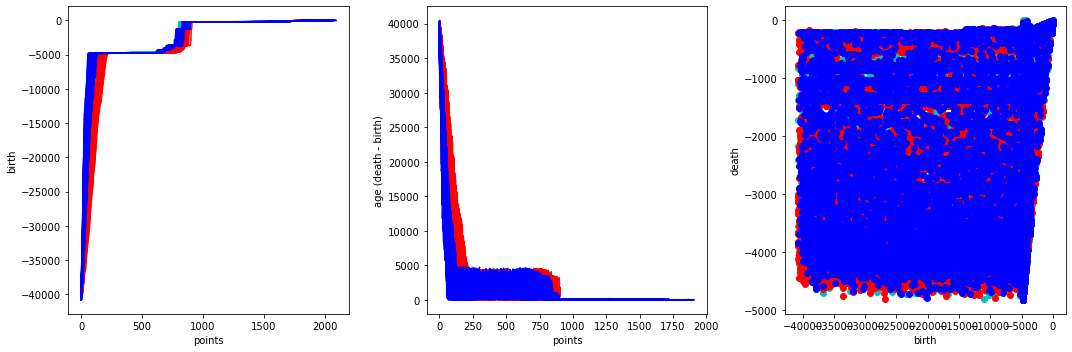

In [14]:
# visualize embeddings
import matplotlib as mpl
import matplotlib.cm as cm

import seaborn as sns

cmap = cm.Blues_r

colors = {0: "b",
          0.1: "c",
          0.2: "m",
          0.3: "r"}
_, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize=(15, 5))
for eps in embeddings:
    if not eps in [0., 0.1, 0.3]: continue
    color = colors[eps]
    for x in embeddings[eps]:
        birth, death = np.transpose(x)
        age = death - birth
        ax1.plot(birth, c=color)
        ax1.set_ylabel("birth")
        ax1.set_xlabel("points")
        # ax2.plot(death, c=color)
        # ax2.set_ylabel("death")
        # ax2.set_xlabel("points")
        ax3.plot(age, c=color)
        ax3.set_ylabel("age (death - birth)")
        ax3.set_xlabel("points")
        ax4.scatter(birth, death, c=color);
        ax4.set_xlabel("birth")
        ax4.set_ylabel("death")
plt.tight_layout()

In [15]:
# Plot performance of the detector
import pandas as pd
import seaborn as sns

df = []
for key in ["supervised_metrics", "unsupervised_metrics"]:
    tmp = evaluation_results[key]
    if key == "unsupervised_metrics":
        sup = False
    else:
        sup = True
    for eps in tmp:
        df.append(dict(sup=sup, eps=eps, auc=tmp[eps]["auc"]["value"],
                       method="PersistentDiagram",
                       arch=lenet_arch.name))
df = pd.DataFrame(df)

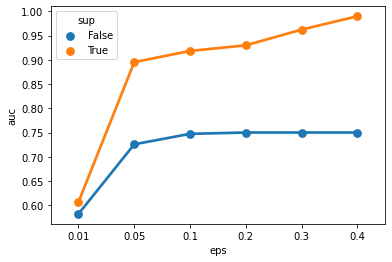

In [16]:
sns.pointplot(data=df, x="eps", y="auc", hue="sup");

In [17]:
df

,sup,eps,auc,method,arch
0,True,0.01,0.60650,PersistentDiagram,mnist_lenet
1,True,0.05,0.89525,PersistentDiagram,mnist_lenet
2,True,0.10,0.91840,PersistentDiagram,mnist_lenet
3,True,0.20,0.93000,PersistentDiagram,mnist_lenet
4,True,0.30,0.96250,PersistentDiagram,mnist_lenet
5,True,0.40,0.99000,PersistentDiagram,mnist_lenet
6,False,0.01,0.58200,PersistentDiagram,mnist_lenet
7,False,0.05,0.72570,PersistentDiagram,mnist_lenet
8,False,0.10,0.74730,PersistentDiagram,mnist_lenet
9,False,0.20,0.75000,PersistentDiagram,mnist_lenet


In [42]:
from tda.embeddings.persistence_landscape import compute_persistence_images

persimgs = {}
for eps in sorted(list(embeddings_train_adv.keys())):
    persimgs[eps], extractor = compute_persistence_images(
        embeddings_train_adv[eps][::10], n_jobs=n_jobs)

PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")


In [44]:
from ipywidgets import interact

eps_list = np.array(list(persimgs.keys()))

@interact
def plot_persistence_images(eps=(0, .5, 0.05),
                            example_index=(0, len(persimgs[eps_list[0]]) - 1)):
    _, ax = plt.subplots(1, 1, figsize=(5, 5))
    closest_i = np.abs(eps - eps_list).argmin()
    eps = eps_list[closest_i]
    persimg = persimgs[eps][example_index]
    extractor.show(persimg, ax=ax)
    # plt.subplots_adjust(wspace=0, hspace=0)
    # plt.tight_layout()

interactive(children=(FloatSlider(value=0.25, description='eps', max=0.5, step=0.05), IntSlider(value=4, descr…

In [131]:
import pandas as pd
import tda.refactor.eval as _eval
reload(_eval)

scores = []
for supervised in [True, False]:
    for kernel_type in [KernelType.PersistenceLandscape,
                        KernelType.SlicedWasserstein]:
        if kernel_type == KernelType.PersistenceLandscape:
            param_space = [{"pixels": (k, k)} for k in [5, 10, 20]]
        elif kernel_type == KernelType.SlicedWasserstein:
            param_space = [dict(M=20, sigma=sigma)
                           for sigma in np.logspace(-3, 3, 7)]
        else:
            raise NotImplementedError(kernel_type)
        df = _eval.evaluate_embeddings(kernel_type,
                                       embeddings_train_clean,
                                       embeddings_test_clean,
                                       embeddings_train_adv,
                                       embeddings_test_adv,
                                       param_space,
                                       supervised=supervised,
                                       n_jobs=n_jobs,
                                       random_state=0)
        scores.append(df)
scores = pd.concat(scores)

2020-05-22 09:59:23,058 - REFACTOR - INFO - Computing scores for PersistenceLandscape (supervised=True)


PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")


2020-05-22 10:00:41,576 - REFACTOR - INFO - eps=0.01, AUC=98.06%


PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")


2020-05-22 10:01:18,589 - REFACTOR - INFO - eps=0.05, AUC=97.08%


PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")


2020-05-22 10:01:56,233 - REFACTOR - INFO - eps=0.10, AUC=100.00%


PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")


2020-05-22 10:02:34,120 - REFACTOR - INFO - eps=0.20, AUC=99.99%


PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")


2020-05-22 10:03:11,437 - REFACTOR - INFO - eps=0.30, AUC=100.00%


PersImage(pixels=(20, 20), spread=None, specs=None, kernel_type="gaussian", weighting_type="linear")


2020-05-22 10:03:49,027 - REFACTOR - INFO - eps=0.40, AUC=100.00%


In [24]:
import pandas as pd
import seaborn as sns

In [151]:
from ipywidgets import interact

df = []
for _, line in scores.iterrows():
    line = line.to_dict()
    low = line.pop("auc.lower_bound")
    val = line.pop("auc.value")
    high = line.pop("auc.upper_bound")
    df += [{"quantile": q, "auc": val, **line}
            for q, val in zip(["lower", "middle", "upper"],
                              [low, val, high])]
df = pd.DataFrame(df)
    
@interact
def plot_scores(supervised=df.supervised.unique()):
    sns.catplot(data=df.loc[df.supervised == supervised], x="eps",
                y="auc", hue="kernel_type", kind="point");

interactive(children=(Dropdown(description='supervised', options=(True,), value=True), Output()), _dom_classes…

In [152]:
df

,quantile,auc,eps,best_params,kernel_type,supervised
0,lower,0.972688,0.01,"{'pixels': (20, 20)}",PersistenceLandscape,True
1,middle,0.980600,0.01,"{'pixels': (20, 20)}",PersistenceLandscape,True
2,upper,0.986906,0.01,"{'pixels': (20, 20)}",PersistenceLandscape,True
3,lower,0.956846,0.05,"{'pixels': (20, 20)}",PersistenceLandscape,True
4,middle,0.970800,0.05,"{'pixels': (20, 20)}",PersistenceLandscape,True
5,upper,0.994744,0.05,"{'pixels': (20, 20)}",PersistenceLandscape,True
6,lower,1.000000,0.10,"{'pixels': (20, 20)}",PersistenceLandscape,True
7,middle,1.000000,0.10,"{'pixels': (20, 20)}",PersistenceLandscape,True
8,upper,1.000000,0.10,"{'pixels': (20, 20)}",PersistenceLandscape,True
9,lower,0.999800,0.20,"{'pixels': (20, 20)}",PersistenceLandscape,True
